In [1]:
import geopandas as gpd
from shapely.geometry import Point, shape
from dem_stitcher.geojson_io import read_geojson_gzip
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from pathlib import Path
import concurrent.futures
from tqdm import tqdm
import requests

# Select MGRS

In [2]:
MGRS_tile_path = '/mnt/aurora-r0/jungkyo/OPERA/DIST-S1/algorithms/dist-s1-model/input_data_research/A_download_burst_data/MGRS_tiles'

mgrs_tile_list = []
with open(MGRS_tile_path) as src:
    mgrs_tile_list = [line.strip() for line in src.readlines()]

In [3]:
print(mgrs_tile_list)

['33MXU', '20KRV', '20LMK', '20LNK', '35LNE', '20KLG', '19LFF', '19LHC', '20LMR', '20LQH', '55WDR', '10VDQ', '51VUK', '10VFN', '12VVN', '11VNG', '11TNK', '51UWB', '50UNE', '50UMG', '35JLK', '22JDN', '35KQS', '48RUV', '35KRV', '43RFP', '35JPN', '32TNR', '33TXF', '15SYC', '51VVH', '51RUQ', '12RYQ', '17TKG', '22KCE', '35NRD', '34TFM', '20HKF', '48RTP', '31PCM', '37UGQ', '55JBN', '13RBQ', '44NLN', '51LYL', '36NXP', '34NCK', '44VNL', '18NYJ', '14UPV', '33LWF', '43VEH', '21LXF', '20HMH', '22JCL', '36NUN', '41WMS', '57WWS', '10TEP', '52TFM', '35SMC', '20MMA', '38QLD', '15SXS', '19LEJ', '18MVT', '53UNQ', '14TNQ', '48PXB', '34NDJ', '36LTK', '16PFT', '32PMR', '34PBS', '36KUU', '34VFP', '22LGK', '34PES', '16TES', '18UYB', '35VLK', '16SFA', '38TQM', '37MCV', '11TNL', '37VCJ', '36KVF', '54STD', '47UQT', '06VVN', '50UMC', '34LDP', '51QUG', '30NXM', '19MFP', '51WVS', '19LCH', '56MKV', '20PKS', '51SXD']


In [4]:
import sqlite3
import geopandas as gpd
from shapely import wkb

MGRS_database = '/mnt/aurora-r0/jungkyo/OPERA/DSWx-S1-final-patch/shared/input_dir/ancillary_data/MGRS_tile.sqlite'
conn = sqlite3.connect(MGRS_database)

# Create a cursor
cursor = conn.cursor()

# Query to fetch geometries based on MGRS tiles
sql_query = """
SELECT mgrs_tile, geometry
FROM mgrs_tile
WHERE mgrs_tile IN ({})
""".format(', '.join(['?'] * len(mgrs_tile_list)))

# Execute the query
cursor.execute(sql_query, mgrs_tile_list)

# Fetch all results
results = cursor.fetchall()

# Convert to GeoDataFrame
geometry_list = []
for row in results:
    mgrs_tile, geometry_binary = row
    geometry = wkb.loads(geometry_binary)

    # Assuming the geometry is stored as a WKT (Well-Known Text) string
    geometry_list.append({
        'mgrs_tile': mgrs_tile,
        'geometry': geometry
    })
print(geometry_list)
# Create a GeoDataFrame from the result
mgrs_gdf = gpd.GeoDataFrame(geometry_list, crs="EPSG:4326")

# Close the database connection
conn.close()

# Print the first few rows to verify
print(mgrs_gdf.head())

[{'mgrs_tile': '06VVN', 'geometry': <POLYGON Z ((-148.869 61.322 0, -146.818 61.334 0, -146.823 60.349 0, -148.8...>}, {'mgrs_tile': '10TEP', 'geometry': <POLYGON Z ((-123 44.253 0, -121.625 44.245 0, -121.648 43.257 0, -123 43.26...>}, {'mgrs_tile': '10VDQ', 'geometry': <POLYGON Z ((-124.983 63.116 0, -122.806 63.129 0, -122.813 62.144 0, -124.9...>}, {'mgrs_tile': '10VFN', 'geometry': <POLYGON Z ((-121.132 61.322 0, -119.085 61.278 0, -119.203 60.294 0, -121.1...>}, {'mgrs_tile': '11TNK', 'geometry': <POLYGON Z ((-117 45.154 0, -115.604 45.145 0, -115.627 44.157 0, -117 44.16...>}, {'mgrs_tile': '11TNL', 'geometry': <POLYGON Z ((-117 46.054 0, -115.581 46.045 0, -115.606 45.057 0, -117 45.06...>}, {'mgrs_tile': '11VNG', 'geometry': <POLYGON Z ((-117 60.436 0, -115.006 60.422 0, -115.064 59.436 0, -117 59.45...>}, {'mgrs_tile': '12RYQ', 'geometry': <POLYGON Z ((-108.983 27.108 0, -107.876 27.088 0, -107.903 26.098 0, -109 2...>}, {'mgrs_tile': '12VVN', 'geometry': <POLYGON Z ((-112.86

# Look at Bursts

In [5]:
# df_aoi = gpd.GeoDataFrame(geometry=[point_geo], crs=CRS.from_epsg(4326))

In [5]:
df_bursts = read_geojson_gzip('input_data_research/opera_burst_ids.geojson.zip')
df_bursts.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


In [6]:
import geopandas as gpd

# --------------------------------------------------------------------------
# df_bursts  : GeoDataFrame of burst footprints   (has a geometry column)
# mgrs_gdf   : GeoDataFrame of MGRS tiles         (column 'mgrs_tile', geometry)

# make sure both are in the same CRS
if df_bursts.crs != mgrs_gdf.crs:
    mgrs_gdf = mgrs_gdf.to_crs(df_bursts.crs)

# --------------------------------------------------------------------------
# spatial join → every burst row gains the 'mgrs_tile' of the tile it
# intersects (if a burst touches >1 tile you’ll get >1 row; drop duplicates
# afterwards if you only need “one tile per burst”).
df_bursts_overlapping = (
    gpd.sjoin(df_bursts,
              mgrs_gdf[['mgrs_tile', 'geometry']],
              how='inner',
              predicate='intersects')
      .reset_index(drop=True)
      .drop(columns='index_right')    # tidy up
)



In [7]:
df_bursts_overlapping['track_number'] = df_bursts_overlapping.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))


In [8]:
print(df_bursts_overlapping)


                                               geometry     burst_id_jpl  \
0     POLYGON ((1.53205 9.59531, 2.30338 9.74628, 2....  t001_000054_iw1   
1     POLYGON ((1.49778 9.76216, 2.26949 9.91301, 2....  t001_000055_iw1   
2     POLYGON ((1.46351 9.92901, 2.23561 10.07974, 2...  t001_000056_iw1   
3     POLYGON ((2.20047 10.14289, 3.01131 10.29959, ...  t001_000056_iw2   
4     POLYGON ((1.42923 10.09586, 2.20174 10.24646, ...  t001_000057_iw1   
...                                                 ...              ...   
6056  POLYGON ((29.07053 3.45301, 29.77694 3.59611, ...  t175_373754_iw3   
6057  POLYGON ((21.36755 41.20504, 22.31292 41.31651...  t175_373981_iw3   
6058  POLYGON ((21.33009 41.37067, 22.27793 41.48207...  t175_373982_iw3   
6059  POLYGON ((21.29554 41.53666, 22.24566 41.64793...  t175_373983_iw3   
6060  POLYGON ((21.25793 41.70227, 22.21056 41.81347...  t175_373984_iw3   

      is_land  is_north_america orbit_pass mgrs_tile  track_number  
0           1     

In [9]:
df_bursts_overlapping[df_bursts_overlapping.burst_id_jpl == 't001_000056_iw2']

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,mgrs_tile,track_number
3,"POLYGON ((2.20047 10.14289, 3.01131 10.29959, ...",t001_000056_iw2,1,False,ASCENDING,31PCM,1


In [10]:
import pandas as pd
from shapely.ops import unary_union


# Assume the following columns exist – rename if needed
#   "flightDirection"   → "A" or "D"   (Ascending / Descending)
#   "relativeOrbit"     → integer track number (1 … 175 for S-1)

# ---------------- pick one track per direction -----------------------------
# Count how many bursts you have for each (direction, track)
counts = (df_bursts_overlapping
          .groupby(["mgrs_tile", "orbit_pass", "track_number"])
          .size()
          .reset_index(name="n_bursts"))

# choose the track with the **largest** burst count for each direction
chosen_tracks = (
    counts.sort_values("n_bursts", ascending=False)      # biggest first
          .groupby(["mgrs_tile", "orbit_pass"], as_index=False)
          .first()                                       # keep the top row
)

print("Chosen tracks:")
print(chosen_tracks[chosen_tracks.mgrs_tile == "31PCM"])
#          flightDirection  relativeOrbit  n_bursts
#   0      A               54             128
#   1      D               25             121

# # ---------------- keep only bursts on those two tracks ---------------------
mask = df_bursts_overlapping.merge(chosen_tracks[["orbit_pass",
                                                 "track_number",
                                                 "mgrs_tile"]],
                                   on=["mgrs_tile", "orbit_pass", "track_number"],
                                   how="inner").index
df_1asc_1des = df_bursts_overlapping.loc[mask].reset_index(drop=True)
print(df_1asc_1des[["burst_id_jpl",
                    "orbit_pass",
                    "track_number","mgrs_tile"]])


Chosen tracks:
   mgrs_tile  orbit_pass  track_number  n_bursts
84     31PCM   ASCENDING             1        15
85     31PCM  DESCENDING            66        15
         burst_id_jpl  orbit_pass  track_number mgrs_tile
0     t001_000054_iw1   ASCENDING             1     31PCM
1     t001_000055_iw1   ASCENDING             1     31PCM
2     t001_000056_iw1   ASCENDING             1     31PCM
3     t001_000056_iw2   ASCENDING             1     31PCM
4     t001_000057_iw1   ASCENDING             1     31PCM
...               ...         ...           ...       ...
3596  t107_228405_iw1  DESCENDING           107     44VNL
3597  t108_230486_iw1  DESCENDING           108     41WMS
3598  t108_230486_iw2  DESCENDING           108     41WMS
3599  t108_230487_iw1  DESCENDING           108     41WMS
3600  t108_230487_iw2  DESCENDING           108     41WMS

[3601 rows x 4 columns]


In [11]:
df_bursts_overlapping = df_1asc_1des



In [12]:
df_bursts_overlapping.to_parquet('Burst_ID_MGRS.parquet')

In [13]:
df_bursts_overlapping

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,mgrs_tile,track_number
0,"POLYGON ((1.53205 9.59531, 2.30338 9.74628, 2....",t001_000054_iw1,1,False,ASCENDING,31PCM,1
1,"POLYGON ((1.49778 9.76216, 2.26949 9.91301, 2....",t001_000055_iw1,1,False,ASCENDING,31PCM,1
2,"POLYGON ((1.46351 9.92901, 2.23561 10.07974, 2...",t001_000056_iw1,1,False,ASCENDING,31PCM,1
3,"POLYGON ((2.20047 10.14289, 3.01131 10.29959, ...",t001_000056_iw2,1,False,ASCENDING,31PCM,1
4,"POLYGON ((1.42923 10.09586, 2.20174 10.24646, ...",t001_000057_iw1,1,False,ASCENDING,31PCM,1
...,...,...,...,...,...,...,...
3596,"POLYGON ((82.18397 58.51600, 80.72450 58.67791...",t107_228405_iw1,1,False,DESCENDING,44VNL,107
3597,"POLYGON ((63.71430 69.40727, 61.57461 69.61105...",t108_230486_iw1,1,False,DESCENDING,41WMS,108
3598,"POLYGON ((61.59316 69.53959, 59.32092 69.72427...",t108_230486_iw2,1,False,DESCENDING,41WMS,108
3599,"POLYGON ((63.58410 69.24640, 61.45978 69.44908...",t108_230487_iw1,1,False,DESCENDING,41WMS,108


In [16]:
counts

,mgrs_tile,orbit_pass,track_number,n_bursts
0,06VVN,ASCENDING,65,17
1,06VVN,ASCENDING,94,9
2,06VVN,ASCENDING,167,18
3,06VVN,DESCENDING,58,14
4,06VVN,DESCENDING,87,9
...,...,...,...,...
456,57WWS,DESCENDING,2,9
457,57WWS,DESCENDING,31,20
458,57WWS,DESCENDING,60,5
459,57WWS,DESCENDING,104,17


In [15]:
df_bursts_overlapping.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,mgrs_tile,track_number
0,"POLYGON ((1.53205 9.59531, 2.30338 9.74628, 2....",t001_000054_iw1,1,False,ASCENDING,31PCM,1
1,"POLYGON ((1.49778 9.76216, 2.26949 9.91301, 2....",t001_000055_iw1,1,False,ASCENDING,31PCM,1
2,"POLYGON ((1.46351 9.92901, 2.23561 10.07974, 2...",t001_000056_iw1,1,False,ASCENDING,31PCM,1
3,"POLYGON ((2.20047 10.14289, 3.01131 10.29959, ...",t001_000056_iw2,1,False,ASCENDING,31PCM,1
4,"POLYGON ((1.42923 10.09586, 2.20174 10.24646, ...",t001_000057_iw1,1,False,ASCENDING,31PCM,1


check if the df_bursts_overlapping was correctly made

In [18]:
mgrs_test = mgrs_gdf[mgrs_gdf.mgrs_tile == '06VVN']
df_bursts_test = df_bursts[df_bursts.geometry.intersects(mgrs_test.unary_union)].reset_index(drop=True)


In [19]:
df_bursts_test = df_bursts_test[df_bursts_test.orbit_pass == 'DESCENDING']

In [20]:
mgrs_test

,mgrs_tile,geometry
0,06VVN,"POLYGON Z ((-148.86875 61.32159 0.00000, -146...."


<Axes: >

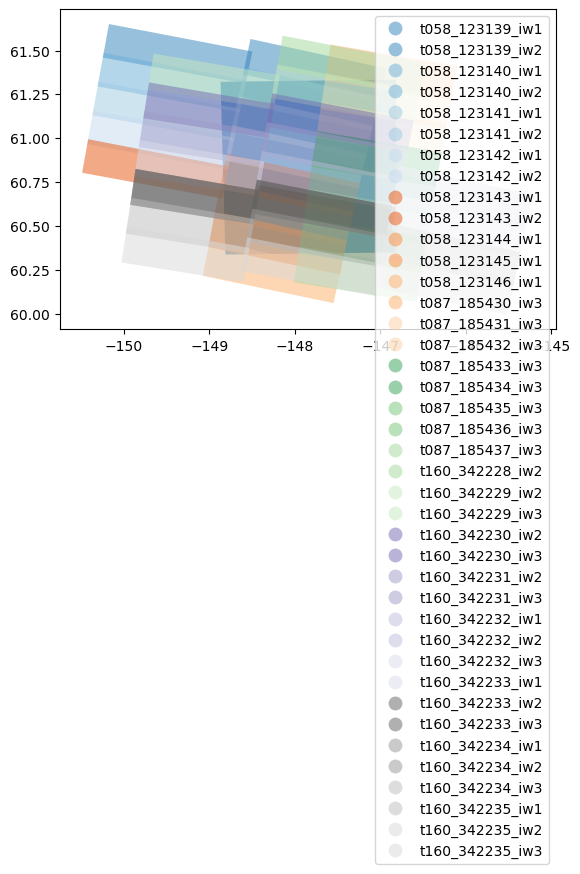

In [21]:
fig, ax = plt.subplots()
mgrs_test.plot(ax=ax)
df_bursts_test.plot(column='burst_id_jpl', categorical=True, alpha=.5, legend=True, cmap='tab20c', ax=ax)

In [22]:
burst_ids = df_bursts_overlapping.burst_id_jpl.tolist()
burst_ids

['t001_000054_iw1',
 't001_000055_iw1',
 't001_000056_iw1',
 't001_000056_iw2',
 't001_000057_iw1',
 't001_000057_iw2',
 't001_000057_iw1',
 't001_000057_iw2',
 't001_000058_iw1',
 't001_000058_iw2',
 't001_000059_iw1',
 't001_000059_iw2',
 't001_000060_iw1',
 't001_000060_iw2',
 't001_000061_iw1',
 't002_002805_iw1',
 't002_002806_iw1',
 't002_002807_iw1',
 't002_002808_iw1',
 't002_002809_iw1',
 't002_002809_iw1',
 't002_002810_iw1',
 't002_002811_iw1',
 't002_002812_iw1',
 't003_005037_iw3',
 't003_005038_iw3',
 't003_005039_iw3',
 't003_005040_iw3',
 't003_005041_iw3',
 't003_005041_iw3',
 't003_005042_iw3',
 't003_005043_iw3',
 't003_005182_iw1',
 't003_005183_iw1',
 't003_005184_iw1',
 't003_005185_iw1',
 't003_005185_iw1',
 't003_005186_iw1',
 't003_005187_iw1',
 't003_005188_iw1',
 't003_005189_iw1',
 't003_006332_iw3',
 't003_006333_iw3',
 't003_006334_iw3',
 't003_006335_iw3',
 't003_006336_iw3',
 't003_006337_iw3',
 't003_006337_iw3',
 't003_006338_iw3',
 't003_006338_iw3',


In [23]:
df_bursts_overlapping['site_id'] = range(1, len(df_bursts_overlapping) + 1)


In [24]:
df_val_bursts = df_bursts_overlapping.drop_duplicates()
# df_val_bursts = df_val_bursts.drop(columns=['index_right'])
df_val_bursts['track_number'] = df_val_bursts.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))
df_val_bursts = df_val_bursts.sort_values(by=['site_id', 'burst_id_jpl']).reset_index(drop=True)
df_val_bursts.rename(columns={'burst_id_jpl': 'jpl_burst_id'}, inplace=True)
df_val_bursts['jpl_burst_id'] = df_val_bursts['jpl_burst_id'].str.upper().str.replace('_', '-')
df_val_bursts.tail()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,mgrs_tile,track_number,site_id
3596,"POLYGON ((82.18397 58.51600, 80.72450 58.67791...",T107-228405-IW1,1,False,DESCENDING,44VNL,107,3597
3597,"POLYGON ((63.71430 69.40727, 61.57461 69.61105...",T108-230486-IW1,1,False,DESCENDING,41WMS,108,3598
3598,"POLYGON ((61.59316 69.53959, 59.32092 69.72427...",T108-230486-IW2,1,False,DESCENDING,41WMS,108,3599
3599,"POLYGON ((63.58410 69.24640, 61.45978 69.44908...",T108-230487-IW1,1,False,DESCENDING,41WMS,108,3600
3600,"POLYGON ((61.47844 69.37763, 59.22295 69.56140...",T108-230487-IW2,1,False,DESCENDING,41WMS,108,3601


In [25]:
df_val_bursts.tail()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,mgrs_tile,track_number,site_id
3596,"POLYGON ((82.18397 58.51600, 80.72450 58.67791...",T107-228405-IW1,1,False,DESCENDING,44VNL,107,3597
3597,"POLYGON ((63.71430 69.40727, 61.57461 69.61105...",T108-230486-IW1,1,False,DESCENDING,41WMS,108,3598
3598,"POLYGON ((61.59316 69.53959, 59.32092 69.72427...",T108-230486-IW2,1,False,DESCENDING,41WMS,108,3599
3599,"POLYGON ((63.58410 69.24640, 61.45978 69.44908...",T108-230487-IW1,1,False,DESCENDING,41WMS,108,3600
3600,"POLYGON ((61.47844 69.37763, 59.22295 69.56140...",T108-230487-IW2,1,False,DESCENDING,41WMS,108,3601


In [26]:
df_val_bursts = df_val_bursts.drop(columns=['is_land'])
df_val_bursts = df_val_bursts.drop(columns=['is_north_america'])


In [ ]:
import asf_search as asf
from multiprocessing import Pool
import pandas as pd

In [28]:
def get_num_bursts(burst_id):
    try:
        # Search for bursts with the given burst_id
        burst_id_new = burst_id.replace('-', '_')
        resp = asf.search(operaBurstID=[burst_id_new], processingLevel='RTC')
        
        # Check if the response has results (assuming resp has a 'results' attribute)
       
        return len(resp)  # Return 0 if no results found
    except Exception as e:
        print(f"Request failed for burst ID: {burst_id} with error: {e}")
        return 0  # Return 0 in case of a request failure

def parallel_get_num_bursts(df):
    # Create a Pool of workers (adjust the number of workers based on your system)
    with Pool(processes=4) as pool:
        # Apply the function to each burst ID in parallel
        results = pool.map(get_num_bursts, df['jpl_burst_id'])
    
    # Add the results to the DataFrame as a new column
    df['n_acquisitions'] = results
    return df

# Apply the function to each row in df_bursts_overlapping and create a new column 'num_bursts_found'
df_val_bursts = parallel_get_num_bursts(df_val_bursts)

# Print the first few rows to verify
print(df_val_bursts.head())

KeyboardInterrupt: 

In [22]:
df_val_bursts2 = df_val_bursts[df_val_bursts['n_acquisitions'] > 0]


KeyError: 'n_acquisitions'

In [22]:
print(df_val_bursts2.head())

                                            geometry     jpl_burst_id  \
0  POLYGON ((1.53205 9.59531, 2.30338 9.74628, 2....  T001-000054-IW1   
1  POLYGON ((1.49778 9.76216, 2.26949 9.91301, 2....  T001-000055-IW1   
2  POLYGON ((1.46351 9.92901, 2.23561 10.07974, 2...  T001-000056-IW1   
3  POLYGON ((2.20047 10.14289, 3.01131 10.29959, ...  T001-000056-IW2   
4  POLYGON ((1.42923 10.09586, 2.20174 10.24646, ...  T001-000057-IW1   

  orbit_pass mgrs_tile  track_number  site_id  n_acquisitions  
0  ASCENDING     31PCM             1        1             103  
1  ASCENDING     31PCM             1        2             103  
2  ASCENDING     31PCM             1        3             103  
3  ASCENDING     31PCM             1        4             103  
4  ASCENDING     31PCM             1        5             103  


In [ ]:
import pandas as pd
import asf_search as asf
from multiprocessing import Pool

import re
from collections.abc import Iterable

# quick URL test – tight enough for ASF links
_URL_RE = re.compile(r'^https?://', re.IGNORECASE)

def collect_urls(feature) -> list[str]:
    """
    Return a clean, deduplicated list of HTTP/HTTPS URLs from one ASF STAC
    feature, no matter how deeply the lists are nested.
    """
    def flatten(obj):
        """yield every string inside obj that looks like a URL"""
        if obj is None:
            return
        if isinstance(obj, str):
            if _URL_RE.match(obj):
                yield obj
        elif isinstance(obj, Iterable) and not isinstance(obj, (bytes, bytearray)):
            for part in obj:
                yield from flatten(part)

    # two possible places ASF puts them
    raw = [
        feature.properties.get("additionalUrls"),
        feature.properties.get("url"),
    ]

    # flatten recursively, keep only real URLs
    flat = list(flatten(raw))

    # deduplicate while preserving order
    return list(dict.fromkeys(flat))

def get_burst_urls_and_datetime(burst_id):
    try:
        burst_id_new = burst_id.replace('-', '_')
        resp = asf.search(operaBurstID=[burst_id_new], processingLevel='RTC')
        
        # Initialize a list to store the URLs and acquisition datetime for each burst
        rows = []
        
        # Extract the URLs and acquisition datetime for each burst
        for item in resp:

            additional_urls = collect_urls(item)
            # print("Clean URLs:")
            # print(*urls, sep="\n")

            properties = item.properties
            acq_datetime = properties.get('stopTime')  # Acquisition time
            # additional_urls = properties.get('additionalUrls', [])
            # additional_urls2 = properties.get('url', [])
            # additional_urls += additional_urls2
            vv_url = None
            vh_url = None
            # For each URL, check if it's VV or VH and add it to the rows
            for url in additional_urls:
                if 'VV.tif' in url:
                    vv_url = url
                elif 'VH.tif' in url:
                    vh_url = url
            rows.append([burst_id, vv_url, vh_url, acq_datetime, item.geometry])  # VV URL

        return rows  # Return all rows for a burst
    except Exception as e:
        print(f"Request failed for burst ID: {burst_id} with error: {e}")
        return []  # Return an empty list in case of failure

def parallel_get_burst_urls(df):
    # Create a Pool of workers (adjust the number of workers based on your system)
    with Pool(processes=4) as pool:
        # Apply the function to each burst ID in parallel and return results
        results = pool.map(get_burst_urls_and_datetime, df['jpl_burst_id'])
    
    # Flatten the list of results into a single list of rows
    rows = [row for sublist in results for row in sublist]
    
    # Create a DataFrame with the appropriate columns
    urls_df = pd.DataFrame(rows, columns=['jpl_burst_id', 'rtc_s1_vv_url', 'rtc_s1_vh_url', 'acq_datetime', 'geometry'])
    
    return urls_df

In [24]:
# Assuming df_val_bursts is the DataFrame with the original burst data
df_val_bursts_urls = parallel_get_burst_urls(df_val_bursts)

# Print the first few rows to verify
print(df_val_bursts_urls.head())

      jpl_burst_id                                      rtc_s1_vv_url  \
0  T001-000054-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
1  T001-000054-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
2  T001-000054-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
3  T001-000054-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
4  T001-000054-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   

                                       rtc_s1_vh_url          acq_datetime  \
0  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2025-05-16T18:03:14Z   
1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2025-05-04T18:03:14Z   
2  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2025-04-22T18:03:14Z   
3  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2025-04-10T18:03:14Z   
4  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2025-03-29T18:03:14Z   

                                            geometry  
0  {'coordinates': [[[1.54363, 9.6018

In [ ]:
df_val_bursts_urls.to_parquet('Burst_MGRS_with_url.parquet')

In [ ]:
df_val_bursts_urls

In [26]:
df_val_bursts_urls

,jpl_burst_id,rtc_s1_vv_url,rtc_s1_vh_url,acq_datetime,geometry
0,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-16T18:03:14Z,"{'coordinates': [[[1.54363, 9.60182], [2.31092..."
1,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-04T18:03:14Z,"{'coordinates': [[[1.54292, 9.60193], [2.31026..."
2,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-22T18:03:14Z,"{'coordinates': [[[1.54354, 9.60234], [2.31079..."
3,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-10T18:03:14Z,"{'coordinates': [[[1.54314, 9.60202], [2.31051..."
4,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-03-29T18:03:14Z,"{'coordinates': [[[1.54128, 9.602], [2.30867, ..."
...,...,...,...,...,...
155236,T105-225496-IW1,None,None,2023-02-15T22:47:05Z,"{'coordinates': [[[-67.29263, -5.48125], [-66...."
155237,T105-225496-IW1,None,None,2023-01-22T22:47:07Z,"{'coordinates': [[[-67.29514, -5.48123], [-66...."
155238,T105-225496-IW1,None,None,2022-12-29T22:47:08Z,"{'coordinates': [[[-67.29443, -5.48121], [-66...."
155239,T105-225496-IW1,None,None,2022-12-05T22:47:09Z,"{'coordinates': [[[-67.29474, -5.48228], [-66...."


In [131]:
# test
get_burst_urls_and_datetime('T105-225496-IW1')

{
  "geometry": {
    "coordinates": [
      [
        [
          -67.29581,
          -5.4822
        ],
        [
          -66.53573,
          -5.31452
        ],
        [
          -66.57196,
          -5.14797
        ],
        [
          -67.33177,
          -5.31547
        ],
        [
          -67.29581,
          -5.4822
        ]
      ]
    ],
    "type": "Polygon"
  },
  "properties": {
    "additionalUrls": [
      "https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T105-225496-IW1_20250511T224701Z_20250513T195103Z_S1A_30_v1.0.iso.xml",
      "https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T105-225496-IW1_20250511T224701Z_20250513T195103Z_S1A_30_v1.0_HH.tif",
      "https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T105-225496-IW1_20250511T224701Z_20250513T195103Z_S1A_30_v1.0_HV.tif",
      "https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T105-225496-IW1_20250511T224701Z_20250513T195103Z_S1A_30_v1.0_mask.tif"
    ],
  

[['T105-225496-IW1',
  None,
  None,
  '2025-05-11T22:47:05Z',
  {'coordinates': [[[-67.29581, -5.4822],
     [-66.53573, -5.31452],
     [-66.57196, -5.14797],
     [-67.33177, -5.31547],
     [-67.29581, -5.4822]]],
   'type': 'Polygon'}],
 ['T105-225496-IW1',
  None,
  None,
  '2025-04-17T22:47:04Z',
  {'coordinates': [[[-67.2947, -5.48197],
     [-66.5345, -5.31423],
     [-66.57074, -5.14768],
     [-67.33067, -5.31524],
     [-67.2947, -5.48197]]],
   'type': 'Polygon'}],
 ['T105-225496-IW1',
  None,
  None,
  '2025-03-24T22:47:04Z',
  {'coordinates': [[[-67.29347, -5.48197],
     [-66.5334, -5.31424],
     [-66.56964, -5.14769],
     [-67.32945, -5.31524],
     [-67.29347, -5.48197]]],
   'type': 'Polygon'}],
 ['T105-225496-IW1',
  None,
  None,
  '2025-02-28T22:47:04Z',
  {'coordinates': [[[-67.29461, -5.48142],
     [-66.5345, -5.31369],
     [-66.57075, -5.14714],
     [-67.33059, -5.31469],
     [-67.29461, -5.48142]]],
   'type': 'Polygon'}],
 ['T105-225496-IW1',
  None,
  

In [ ]:
print(df_val_bursts_urls)


           jpl_burst_id                                      rtc_s1_vv_url  \
0       T001-000055-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
1       T001-000055-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
2       T001-000055-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
3       T001-000055-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
4       T001-000055-IW1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...   
...                 ...                                                ...   
155015  T105-225496-IW1                                               None   
155016  T105-225496-IW1                                               None   
155017  T105-225496-IW1                                               None   
155018  T105-225496-IW1                                               None   
155019  T105-225496-IW1                                               None   

                                            rtc_s1_vh_url  \
0 

In [128]:
print(df_val_bursts_urls[df_val_bursts_urls.jpl_burst_id == 'T001-000055-IW1'].to_string())

        jpl_burst_id                                                                                                                      rtc_s1_vv_url                                                                                                                      rtc_s1_vh_url          acq_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [27]:
df_val_bursts_urls2 = df_val_bursts_urls[
    df_val_bursts_urls["rtc_s1_vh_url"].notna()
].copy()  

In [28]:
df_val_bursts_urls2

,jpl_burst_id,rtc_s1_vv_url,rtc_s1_vh_url,acq_datetime,geometry
0,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-16T18:03:14Z,"{'coordinates': [[[1.54363, 9.60182], [2.31092..."
1,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-04T18:03:14Z,"{'coordinates': [[[1.54292, 9.60193], [2.31026..."
2,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-22T18:03:14Z,"{'coordinates': [[[1.54354, 9.60234], [2.31079..."
3,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-10T18:03:14Z,"{'coordinates': [[[1.54314, 9.60202], [2.31051..."
4,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-03-29T18:03:14Z,"{'coordinates': [[[1.54128, 9.602], [2.30867, ..."
...,...,...,...,...,...
155068,T105-225443-IW3,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2021-02-19T22:43:48Z,"{'coordinates': [[[-63.77724, -13.83515], [-63..."
155069,T105-225443-IW3,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2021-02-07T22:43:48Z,"{'coordinates': [[[-63.77755, -13.83509], [-63..."
155070,T105-225443-IW3,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2021-01-26T22:43:49Z,"{'coordinates': [[[-63.77786, -13.8346], [-63...."
155071,T105-225443-IW3,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2021-01-14T22:43:49Z,"{'coordinates': [[[-63.778, -13.83492], [-63.0..."


In [29]:
print(df_val_bursts_urls2[df_val_bursts_urls2.jpl_burst_id == 'T001-000055-IW1']['acq_datetime'].to_string())

103    2025-05-16T18:03:17Z
104    2025-05-04T18:03:17Z
105    2025-04-22T18:03:17Z
106    2025-04-10T18:03:17Z
107    2025-03-29T18:03:17Z
108    2025-03-17T18:03:16Z
109    2025-03-05T18:03:16Z
110    2025-02-21T18:03:16Z
111    2025-02-09T18:03:17Z
112    2025-01-28T18:03:17Z
113    2025-01-16T18:03:18Z
114    2025-01-04T18:03:19Z
115    2024-12-23T18:03:20Z
116    2024-12-11T18:03:21Z
117    2024-11-29T18:03:22Z
118    2024-11-17T18:03:23Z
119    2024-11-05T18:03:23Z
120    2024-10-24T18:03:23Z
121    2024-10-12T18:03:23Z
122    2024-09-30T18:03:23Z
123    2024-09-18T18:03:23Z
124    2024-09-06T18:03:22Z
125    2024-08-25T18:03:22Z
126    2024-08-13T18:03:22Z
127    2024-08-01T18:03:22Z
128    2024-07-20T18:03:22Z
129    2024-06-26T18:03:23Z
130    2024-06-14T18:03:24Z
131    2024-06-02T18:03:24Z
132    2024-05-21T18:03:24Z
133    2024-05-09T18:03:25Z
134    2024-04-27T18:03:25Z
135    2024-04-15T18:03:24Z
136    2024-04-03T18:03:24Z
137    2024-03-22T18:03:23Z
138    2024-03-10T18

In [135]:
df_test = df_val_bursts[df_val_bursts.jpl_burst_id == 'T001-000055-IW1']
df_test.head()

,geometry,jpl_burst_id,orbit_pass,mgrs_tile,track_number,site_id,n_acquisitions
1,"POLYGON ((1.49778 9.76216, 2.26949 9.91301, 2....",T001-000055-IW1,ASCENDING,31PCM,1,2,103


In [30]:
df_val_bursts_urls2.to_parquet('validation_bursts_all_new100_v3.parquet')


## MGRS analysis 

In [31]:
print(mgrs_gdf.head())

  mgrs_tile                                           geometry
0     06VVN  POLYGON Z ((-148.86875 61.32159 0.00000, -146....
1     10TEP  POLYGON Z ((-123.00025 44.25342 0.00000, -121....
2     10VDQ  POLYGON Z ((-124.98311 63.11566 0.00000, -122....
3     10VFN  POLYGON Z ((-121.13199 61.32160 0.00000, -119....
4     11TNK  POLYGON Z ((-117.00025 45.15384 0.00000, -115....


In [32]:
worldcover_path = '/mnt/aurora-r0/jungkyo/data/landcover.vrt'

In [33]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_window
from shapely.ops import transform
from functools import partial
import pyproj
import numpy as np
import pandas as pd

# ----------------------------------------------------------------------
# Optional: human-readable names for the ESA WorldCover classes (v2021)
CLASS_MAP = {
     10: "Tree_cover",
     20: "Shrubland",
     30: "Grassland",
     40: "Cropland",
     50: "Built_up",
     60: "Bare_sparse",
     70: "Snow_ice",
     80: "Permanent_water",
     90: "Herbaceous_wetland",
     95: "Mangroves",
    100: "Moss_lichen",
}

def landcover_stats_by_tile(
    mgrs_vector_path: str | gpd.GeoDataFrame,
    worldcover_vrt_path: str,
    nodata: int | float = 0,
    class_map: dict[int, str] | None = CLASS_MAP,
) -> pd.DataFrame:
    """
    Compute per-tile land-cover percentages from the ESA WorldCover VRT.

    Parameters
    ----------
    mgrs_vector_path : path to the MGRS tile polygons (or a loaded GeoDataFrame)
                       Must contain a column 'mgrs_tile_id'.
    worldcover_vrt_path : path to ESA WorldCover *.vrt*
    nodata : raster nodata value (default 0 in the official product)
    class_map : dict mapping class codes to readable names.

    Returns
    -------
    DataFrame with one row per tile and `{class}_count`, `{class}_pct` columns.
    """
    # ------------------------------------------------------------------ read vectors
    gdf = (
        gpd.read_file(mgrs_vector_path)
        if not isinstance(mgrs_vector_path, gpd.GeoDataFrame)
        else mgrs_vector_path.copy()
    )
    if "mgrs_tile" not in gdf.columns:
        raise ValueError("Vector layer must contain a 'mgrs_tile' column")

    # ------------------------------------------------------------------ open raster once
    results: list[dict] = []
    with rasterio.open(worldcover_vrt_path) as src:
        wc_crs = src.crs

        # iterate tiles
        for _, row in gdf.iterrows():
            geom = row.geometry

            # re-project geometry to raster CRS if needed
            if gdf.crs != wc_crs:
                project = partial(
                    pyproj.transform, pyproj.CRS(gdf.crs), pyproj.CRS(wc_crs)
                )
                geom = transform(project, geom)

            # quick reject if tile lies completely outside raster extent
            if not geom.intersects(geom.__class__.from_bounds(*src.bounds)):
                continue

            # read only the window that overlaps the geometry (no resampling)
            window = geometry_window(src, [geom], pixel_precision=3)
            # (< 1 MB for a single 10 km tile; very fast)
            # subarray, _ = mask(
            #     src, [geom], crop=True, nodata=nodata, filled=False, window=window
            # )
            subarray, _ = mask(
                src, [geom],
                crop=True,
                nodata=nodata,
                filled=False          # keeps a masked array, no resampling
            )
            data = subarray[0]
            # drop nodata pixels
            data = data[~data.mask] if np.ma.isMaskedArray(data) else data
            data = data[data != nodata]

            if data.size == 0:
                # tile has no valid pixels (ocean-only, etc.)
                continue

            # pixel counts and percentages
            values, counts = np.unique(data, return_counts=True)
            total = counts.sum()

            record = {
                "mgrs_tile": row["mgrs_tile"],
                "total_pixels": int(total),
            }
            for val, cnt in zip(values, counts):
                name = class_map.get(val, f"class_{val}") if class_map else f"class_{val}"
                record[f"{name}_count"] = int(cnt)
                record[f"{name}_pct"] = 100.0 * cnt / total
            results.append(record)

    return pd.DataFrame(results)




In [ ]:
mgrs_gpkg   = mgrs_gdf
worldcover  = worldcover_path
df_stats    = landcover_stats_by_tile(mgrs_gpkg, worldcover)

# save or inspect
# df_stats.to_csv("mgrs_worldcover_stats.csv", index=False)
print(df_stats.head())

  mgrs_tile  total_pixels  Tree_cover_count  Tree_cover_pct  Shrubland_count  \
0     06VVN     286727003          32688797       11.400669          14030.0   
1     10TEP     194163253         178258100       91.808361         125047.0   
2     10VDQ     303833326         202864966       66.768504       30633470.0   
3     10VFN     286326511         188758053       65.924057       40302337.0   
4     11TNK     197112287          90611492       45.969479         925040.0   

   Shrubland_pct  Grassland_count  Grassland_pct  Built_up_count  \
0       0.004893         37520299      13.085722            9421   
1       0.064403          9384676       4.833395          346008   
2      10.082327         36804532      12.113395           10849   
3      14.075657         36930439      12.898016           21489   
4       0.469296         89628366      45.470715          431917   

   Built_up_pct  ...  Permanent_water_count  Permanent_water_pct  \
0      0.003286  ...              12712876

In [35]:
from scipy.stats import entropy

In [36]:
count_cols  = [c for c in df_stats.columns if c.endswith("_count")]
counts_df   = df_stats.set_index("mgrs_tile")[count_cols]
counts_df.columns = [c.replace("_count", "") for c in count_cols]

In [37]:
counts_df

,Tree_cover,Shrubland,Grassland,Built_up,Bare_sparse,Snow_ice,Permanent_water,Herbaceous_wetland,Moss_lichen,Cropland,Mangroves
mgrs_tile,,,,,,,,,,,
06VVN,32688797,14030.0,37520299,9421,6710865,72619825.0,127128768,165832.0,9869166.0,NaN,NaN
10TEP,178258100,125047.0,9384676,346008,2187874,118585.0,2933228,56802.0,334393.0,418540.0,NaN
10VDQ,202864966,30633470.0,36804532,10849,6727125,172719.0,12390128,151159.0,14077454.0,924.0,NaN
10VFN,188758053,40302337.0,36930439,21489,84195,8.0,11744544,8272441.0,212814.0,191.0,NaN
11TNK,90611492,925040.0,89628366,431917,2123047,115.0,3047572,7981.0,7466191.0,2870566.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
54STD,54073677,972.0,1437968,9326484,1320569,NaN,83450099,6332.0,NaN,2909692.0,NaN
55JBN,75882087,3070964.0,74415277,2601,1604956,NaN,18697,NaN,NaN,10061.0,NaN
55WDR,148064195,100471.0,89829875,5664,992605,284450.0,46615710,74578767.0,12279115.0,NaN,NaN


In [38]:
def greedy_entropy_selection(counts_df: pd.DataFrame,
                             n_tiles: int = 10,
                             normalise_entropy: bool = True) -> list[str]:
    # enforce integer matrix, no NaN
    counts = counts_df.fillna(0).astype(np.int64).to_numpy()

    tiles   = counts_df.index.to_numpy()
    n_class = counts.shape[1]
    max_ent = np.log(n_class) if normalise_entropy else 1.0

    agg     = np.zeros(n_class, dtype=np.int64)
    selected_idx = []

    remaining_mask = np.ones(len(tiles), dtype=bool)

    for _ in range(n_tiles):
        # candidate totals = current agg + every remaining row
        cand_totals = counts[remaining_mask] + agg          # 2-D array
        probs       = cand_totals / cand_totals.sum(axis=1, keepdims=True)
        ent         = entropy(probs.T) / max_ent

        best_local  = ent.argmax()
        global_idx  = np.flatnonzero(remaining_mask)[best_local]

        selected_idx.append(global_idx)
        agg += counts[global_idx]
        remaining_mask[global_idx] = False

    return tiles[selected_idx].tolist()


In [39]:
chosen_10 = greedy_entropy_selection(counts_df, n_tiles=10)

print("Chosen tiles:", chosen_10)
# Optional: inspect the final aggregate distribution
final_mix = counts_df.loc[chosen_10].sum()
final_probs = (final_mix / final_mix.sum()).sort_values(ascending=False)
print("\nAggregate class percentages:")
print((final_probs * 100).round(2).astype(str) + " %")

Chosen tiles: ['33TXF', '35LNE', '38QLD', '06VVN', '51RUQ', '53UNQ', '31PCM', '13RBQ', '32TNR', '57WWS']

Aggregate class percentages:
Permanent_water       18.85 %
Grassland             15.41 %
Herbaceous_wetland    14.75 %
Tree_cover            13.85 %
Cropland              10.56 %
Shrubland             10.27 %
Bare_sparse            8.72 %
Snow_ice               3.62 %
Built_up                3.3 %
Moss_lichen            0.68 %
Mangroves               0.0 %
dtype: object


In [40]:
filtered = df_bursts_overlapping[ df_bursts_overlapping["mgrs_tile"].isin(chosen_10) ]
filtered = filtered.reset_index(drop=True)


In [41]:
filtered['burst_id_jpl'] = filtered['burst_id_jpl'].str.upper().str.replace('_', '-')


In [42]:
filtered

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,mgrs_tile,track_number,site_id
0,"POLYGON ((1.53205 9.59531, 2.30338 9.74628, 2....",T001-000054-IW1,1,False,ASCENDING,31PCM,1,1
1,"POLYGON ((1.49778 9.76216, 2.26949 9.91301, 2....",T001-000055-IW1,1,False,ASCENDING,31PCM,1,2
2,"POLYGON ((1.46351 9.92901, 2.23561 10.07974, 2...",T001-000056-IW1,1,False,ASCENDING,31PCM,1,3
3,"POLYGON ((2.20047 10.14289, 3.01131 10.29959, ...",T001-000056-IW2,1,False,ASCENDING,31PCM,1,4
4,"POLYGON ((1.42923 10.09586, 2.20174 10.24646, ...",T001-000057-IW1,1,False,ASCENDING,31PCM,1,5
...,...,...,...,...,...,...,...,...
390,"POLYGON ((121.77847 30.92890, 120.95273 31.056...",T105-224277-IW3,1,False,DESCENDING,51RUQ,105,3497
391,"POLYGON ((122.66082 30.67404, 121.72969 30.823...",T105-224278-IW2,1,False,DESCENDING,51RUQ,105,3498
392,"POLYGON ((121.74429 30.76277, 120.92003 30.890...",T105-224278-IW3,1,False,DESCENDING,51RUQ,105,3499
393,"POLYGON ((122.62503 30.50783, 121.69558 30.657...",T105-224279-IW2,1,False,DESCENDING,51RUQ,105,3500


In [138]:
df_val_bursts_urls2 = pd.read_parquet('validation_bursts_all_new100_v3.parquet')


In [139]:
df_val_bursts_urls2
print(df_val_bursts_urls2[df_val_bursts_urls2.jpl_burst_id == 'T001-000055-IW1']['acq_datetime'].to_string())

0      2025-05-16T18:03:17Z
1      2025-05-04T18:03:17Z
2      2025-04-22T18:03:17Z
3      2025-04-10T18:03:17Z
4      2025-03-29T18:03:17Z
5      2025-03-17T18:03:16Z
6      2025-03-05T18:03:16Z
7      2025-02-21T18:03:16Z
8      2025-02-09T18:03:17Z
9      2025-01-28T18:03:17Z
10     2025-01-16T18:03:18Z
11     2025-01-04T18:03:19Z
12     2024-12-23T18:03:20Z
13     2024-12-11T18:03:21Z
14     2024-11-29T18:03:22Z
15     2024-11-17T18:03:23Z
16     2024-11-05T18:03:23Z
17     2024-10-24T18:03:23Z
18     2024-10-12T18:03:23Z
19     2024-09-30T18:03:23Z
20     2024-09-18T18:03:23Z
21     2024-09-06T18:03:22Z
22     2024-08-25T18:03:22Z
23     2024-08-13T18:03:22Z
24     2024-08-01T18:03:22Z
25     2024-07-20T18:03:22Z
26     2024-06-26T18:03:23Z
27     2024-06-14T18:03:24Z
28     2024-06-02T18:03:24Z
29     2024-05-21T18:03:24Z
30     2024-05-09T18:03:25Z
31     2024-04-27T18:03:25Z
32     2024-04-15T18:03:24Z
33     2024-04-03T18:03:24Z
34     2024-03-22T18:03:23Z
35     2024-03-10T18

In [ ]:
common = (
    df_val_bursts_urls2
    .merge(
        filtered[['burst_id_jpl']],
        right_on='burst_id_jpl', 
        left_on='jpl_burst_id',
        how='inner'
    )
    .drop(columns='burst_id_jpl')
)

In [44]:
print(common[common.jpl_burst_id == 'T001-000055-IW1']['acq_datetime'].to_string())
print(len(common[common.jpl_burst_id == 'T001-000055-IW1']['acq_datetime']))

103    2025-05-16T18:03:17Z
104    2025-05-04T18:03:17Z
105    2025-04-22T18:03:17Z
106    2025-04-10T18:03:17Z
107    2025-03-29T18:03:17Z
108    2025-03-17T18:03:16Z
109    2025-03-05T18:03:16Z
110    2025-02-21T18:03:16Z
111    2025-02-09T18:03:17Z
112    2025-01-28T18:03:17Z
113    2025-01-16T18:03:18Z
114    2025-01-04T18:03:19Z
115    2024-12-23T18:03:20Z
116    2024-12-11T18:03:21Z
117    2024-11-29T18:03:22Z
118    2024-11-17T18:03:23Z
119    2024-11-05T18:03:23Z
120    2024-10-24T18:03:23Z
121    2024-10-12T18:03:23Z
122    2024-09-30T18:03:23Z
123    2024-09-18T18:03:23Z
124    2024-09-06T18:03:22Z
125    2024-08-25T18:03:22Z
126    2024-08-13T18:03:22Z
127    2024-08-01T18:03:22Z
128    2024-07-20T18:03:22Z
129    2024-06-26T18:03:23Z
130    2024-06-14T18:03:24Z
131    2024-06-02T18:03:24Z
132    2024-05-21T18:03:24Z
133    2024-05-09T18:03:25Z
134    2024-04-27T18:03:25Z
135    2024-04-15T18:03:24Z
136    2024-04-03T18:03:24Z
137    2024-03-22T18:03:23Z
138    2024-03-10T18

In [45]:
common

,jpl_burst_id,rtc_s1_vv_url,rtc_s1_vh_url,acq_datetime,geometry
0,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-16T18:03:14Z,"{'coordinates': [[[1.54363, 9.60182], [2.31092..."
1,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-04T18:03:14Z,"{'coordinates': [[[1.54292, 9.60193], [2.31026..."
2,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-22T18:03:14Z,"{'coordinates': [[[1.54354, 9.60234], [2.31079..."
3,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-10T18:03:14Z,"{'coordinates': [[[1.54314, 9.60202], [2.31051..."
4,T001-000054-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-03-29T18:03:14Z,"{'coordinates': [[[1.54128, 9.602], [2.30867, ..."
...,...,...,...,...,...
19970,T090-191949-IW3,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-09-11T21:05:00Z,"{'coordinates': [[[136.10489, 49.00733], [135...."
19971,T090-191950-IW2,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-09-11T21:05:02Z,"{'coordinates': [[[137.25537, 48.7636], [136.0..."
19972,T090-191950-IW3,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-09-11T21:05:03Z,"{'coordinates': [[[136.06285, 48.84221], [134...."
19973,T090-191951-IW2,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-09-11T21:05:04Z,"{'coordinates': [[[137.21141, 48.59841], [135...."


In [143]:
common.to_parquet('validation_bursts_all_new100_v3_filtered.parquet')


In [93]:
burst_id_new = 'T001_000054_IW1'
resp = asf.search(operaBurstID=[burst_id_new], processingLevel='RTC')

In [ ]:
import re
from collections.abc import Iterable

# quick URL test – tight enough for ASF links
_URL_RE = re.compile(r'^https?://', re.IGNORECASE)

def collect_urls(feature) -> list[str]:
    """
    Return a clean, deduplicated list of HTTP/HTTPS URLs from one ASF STAC
    feature, no matter how deeply the lists are nested.
    """
    def flatten(obj):
        """yield every string inside obj that looks like a URL"""
        if obj is None:
            return
        if isinstance(obj, str):
            if _URL_RE.match(obj):
                yield obj
        elif isinstance(obj, Iterable) and not isinstance(obj, (bytes, bytearray)):
            for part in obj:
                yield from flatten(part)

    # two possible places ASF puts them
    raw = [
        feature.properties.get("additionalUrls"),
        feature.properties.get("url"),
    ]

    # flatten recursively, keep only real URLs
    flat = list(flatten(raw))

    # deduplicate while preserving order
    return list(dict.fromkeys(flat))




Clean URLs:
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T001-000054-IW1_20241012T180317Z_20241012T222936Z_S1A_30_v1.0.h5
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T001-000054-IW1_20241012T180317Z_20241012T222936Z_S1A_30_v1.0.iso.xml
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T001-000054-IW1_20241012T180317Z_20241012T222936Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T001-000054-IW1_20241012T180317Z_20241012T222936Z_S1A_30_v1.0_mask.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T001-000054-IW1_20241012T180317Z_20241012T222936Z_S1A_30_v1.0_VH.tif


In [ ]:
# ---------------------------------------------------------------
# Try it again on the problematic feature
urls = collect_urls(resp[18])
print("Clean URLs:")
print(*urls, sep="\n")
